# Line source spectral fitting example (GRB)

**To run this, you need the binned data (grb_bkg_binned_data_511.hdf5, grb_binned_data_511.hdf5, & bkg_binned_data_full_511.hdf5) and detector response (Isotropic.511keV.p.binnedimaging.imagingresponse_nside16.area.h5), which are available on wasabi in cosi-pipeline-public/ComptonSphere/mini-DC2 and can be downloaded using the first cell of this notebook. The binned data are simulations of a GRB and background produced using the Compton sphere mass model.**

This notebook fits the spectrum of a GRB simulated using MEGAlib and combined with background which is constant in time.

[3ML](https://threeml.readthedocs.io/) is a high-level interface that allows multiple datasets from different instruments to be used coherently to fit the parameters of source model. A source model typically consists of a list of sources with parametrized spectral shapes, sky locations and, for extended sources, shape. Polarization is also possible. A "coherent" analysis, in this context, means that the source model parameters are fitted using all available datasets simultanously, rather than performing individual fits and finding a well-suited common model a posteriori. 

In order for a dataset to be included in 3ML, each instrument needs to provide a "plugin". Each plugin is responsible for reading the data, convolving the source model (provided by 3ML) with the instrument response, and returning a likelihood. In our case, we'll compute a binned Poisson likelihood:

$$
\log \mathcal{L}(\mathbf{x}) = \sum_i \log \frac{\lambda_i(\mathbf{x})^{d_i} \exp (-\lambda_i)}{d_i!}
$$

where $d_i$ are the counts on each bin and $\lambda_i$ are the expected counts given a source model with parameters $\mathbf{x}$. 

In this example, we will fit a single point source with a known location. We'll assume the background is known and fixed up to a scaling factor. Finally, we will fit both a constant function: 

$$
f(x) = k
$$

where $k$ (normalization) is the free parameter, and a Dirac Delta function:

$$
f(x) = \begin{cases} \text{value} & x = \text{zero_point} \\ 0 & x \neq \text{zero_point} \end{cases}
$$

where $\text{value}$ (normalization), is the free parameter, while $\text{zero_point}$ is the value at which the Dirac Delta function spikes, which is fixed (in this notebook, to 511 keV).

Considering these assumptions:

$$
\lambda_i(\mathbf{x}) = B*b_i + s_i(\mathbf{x})
$$

where $B*b_i$ are the estimated counts due to background in each bin of the Compton data space with $B$ the amplitude and $b_i$ the shape of the background, and $s_i$ are the corresponding expected counts from the source, the goal is then to find the values of $\mathbf{x} = [k]$ or $\mathbf{x} = [\text{value}]$ and $B$ that maximize $\mathcal{L}$. These are the best estimations of the parameters.

The final module needs to also fit the time-dependent background, handle multiple point-like and extended sources, as well as all the spectral models supported by 3ML. Eventually, it will also fit the polarization angle. However, this simple example already contains all the necessary pieces to do a fit.

In [1]:
from cosipy import COSILike, test_data, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse

from scoords import SpacecraftFrame

from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from threeML import Constant, DiracDelta, PointSource, Model, JointLikelihood, DataList
from astromodels import Parameter

from pathlib import Path

import os

18:32:20 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=723260;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=848796;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=540783;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=472047;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=690193;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=510227;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=433351;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=1082;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=110879;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=844314;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=373691;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=30556;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=141082;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=959189;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=64129;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=126093;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

18:32:20 INFO      Starting 3ML!                                                                     ]8;id=113844;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=342465;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=197085;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=541034;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=154804;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=489653;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=618865;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=982385;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=181988;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=458561;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=691906;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=84585;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=311802;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=659308;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

18:32:21 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=598001;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=940684;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=352683;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=146784;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=868909;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=533905;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

18:32:21 WARNING   No fermitools installed                                              ]8;id=598893;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=959179;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=923639;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=808501;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=893300;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=568687;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=671494;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=173189;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## Read in binned data

Download the data and detector response from wasabi. You can skip this cell if you already have downloaded the files

In [3]:
file_list = ['bkg_binned_data_full_511.hdf5','grb_binned_data_511.hdf5','grb_bkg_binned_data_511.hdf5','Isotropic.511keV.p.binnedimaging.imagingresponse_nside16.area.h5']

for each in file_list:
    os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key ComptonSphere/mini-DC2/%s --endpoint-url=https://s3.us-west-1.wasabisys.com %s" %(each,each))

Define the path to the directory containing the data, detector response, orientation file, and yaml files

In [2]:
data_path = Path("/path/to/files")

Read in the spacecraft orientation file & select the beginning and end times of the GRB

In [3]:
ori = SpacecraftFile.parse_from_file(data_path / "20280301_first_2hrs.ori")
tmin = Time(1835479878.0,format = 'unix')
tmax = Time(1835479880.0,format = 'unix')
sc_orientation = ori.source_interval(tmin, tmax)

Create BinnedData objects for the GRB only, GRB+background, and background only. The GRB only simulation is not used for the spectral fit, but can be used to compare the fitted spectrum to the source simulation

In [4]:
grb = BinnedData(data_path / "grb_511.yaml")
grb_bkg = BinnedData(data_path / "grb_511.yaml")
bkg = BinnedData(data_path / "background_511.yaml")

Load binned .hdf5 files

In [5]:
grb.load_binned_data_from_hdf5(binned_data=data_path / "grb_binned_data_511.hdf5")
grb_bkg.load_binned_data_from_hdf5(binned_data=data_path / "grb_bkg_binned_data_511.hdf5")
bkg.load_binned_data_from_hdf5(binned_data=data_path / "bkg_binned_data_full_511.hdf5")

Define the path to the detector response

In [6]:
dr = str(data_path / "Isotropic.511keV.p.binnedimaging.imagingresponse_nside16.area.h5") # path to detector response

## Perform spectral fit (constant function)

Set background parameter, which is used to fit the amplitude of the background, and instantiate the COSI 3ML plugin

In [7]:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    2.8e-4,                                                   # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = dr,                                                      # detector response
                data = grb_bkg.binned_data.project('Em', 'Phi', 'PsiChi'),    # data (source+background)
                bkg = bkg.binned_data.project('Em', 'Phi', 'PsiChi'),         # background model 
                sc_orientation = sc_orientation,                              # spacecraft orientation
                nuisance_param = bkg_par,                                     # background parameter
                coordsys='spacecraftframe')                                     

Define a point source at the known location with a constant spectrum and add it to the model

In [8]:
l = 340.
b = 45.

k = 5/4 / u.keV / u.s / u.cm / u.cm         # Setting parameters to something reasonable helps the fitting to converge
spectrum = Constant(k=k.value)
spectrum.k.unit = k.unit

source = PointSource("source",                     # Name of source (arbitrary, but needs to be unique)
                     l = l,                        # Longitude (deg)
                     b = b,                        # Latitude (deg)
                     spectral_shape = spectrum)    # Spectral model

# Optional: free the position parameters
#source.position.l.free = True
#source.position.b.free = True

model = Model(source)                              # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

# Optional: if you want to call get_log_like manually, then you also need to set the model manually
# 3ML does this internally during the fit though
cosi.set_model(model)

Now converting to the Spacecraft frame...
Conversion completed!


Gather all plugins and combine with the model in a JointLikelihood object, then perform maximum likelihood fit

In [9]:
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = False)

like.fit()

15:50:56 INFO      set the minimizer to minuit                                             ]8;id=527386;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=507337;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply

There are bins in which the total expected counts = 0 but data != 0, making log-likelihood = -inf. Masking these bins.

WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply

There are bins in which the total expected counts = 0 but data != 0, making log-likelihood = -inf. Masking these bins.

WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING R

15:50:58 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=383654;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=274936;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Constant.k,1.2309 +/- 0.0035,1 / (cm2 keV s)
background_cosi,(7.3 +/- 0.4) x 10^-3,


Correlation matrix:

1.00,-0.23
-0.23,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-62559.736853
total,-62559.736853


Values of statistical measures:

,statistical measures
AIC,-125121.473707
BIC,-125119.473707


(                                    value  negative_error  positive_error  \
 source.spectrum.main.Constant.k  1.230907       -0.003605        0.003581   
 background_cosi                  0.007252       -0.000361        0.000359   
 
                                     error             unit  
 source.spectrum.main.Constant.k  0.003593  1 / (cm2 keV s)  
 background_cosi                  0.000360                   ,
        -log(likelihood)
 cosi      -62559.736853
 total     -62559.736853)

## Error propagation and plotting (constant function)

Define spectrum injected into MEGAlib. A Dirac Delta function was the true input, but because evaluate_at(e) only returns a value for e=511. keV, the cell in this section which calculates the flux will not work as written. Therefore, we are using an equivalent constant spectrum for the 509-513 keV bin

In [10]:
k_inj = 5/4 / u.cm / u.cm / u.s / u.keV

spectrum_inj = Constant(k=k_inj.value)

spectrum_inj.k.unit = k_inj.unit

The summary of the results above tell you the optimal values of the parameters, as well as the errors. Propogate the errors to the "evaluate_at" method of the spectrum

In [11]:
results = like.results

print(results.display())

parameters = {par.name:results.get_variates(par.path)
              for par in results.optimized_model["source"].parameters.values()
              if par.free}

results_err = results.propagate(results.optimized_model["source"].spectrum.main.shape.evaluate_at, **parameters)

print(results.optimized_model["source"])

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Constant.k,1.2309 +/- 0.0035,1 / (cm2 keV s)
background_cosi,(7.3 +/- 0.4) x 10^-3,


Correlation matrix:

1.00,-0.23
-0.23,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-62559.736853
total,-62559.736853


Values of statistical measures:

,statistical measures
AIC,-125121.473707
BIC,-125119.473707


None
  * source (point source):
    * position:
      * l:
        * value: 340.0
        * desc: Galactic longitude
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * b:
        * value: 45.0
        * desc: Galactic latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Constant:
          * k:
            * value: 1.2309072340682037
            * desc: Constant value
            * min_value: null
            * max_value: null
            * unit: keV-1 s-1 cm-2
            * is_normalization: false
        * polarization: {}



Evaluate the flux and errors at a range of energies for the fitted and injected spectra

In [12]:
energy = np.geomspace(509*u.keV,513*u.keV).to_value(u.keV)

flux_lo = np.zeros_like(energy)
flux_median = np.zeros_like(energy)
flux_hi = np.zeros_like(energy)
flux_inj = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux = results_err(e)
    flux_median[i] = flux.median
    flux_lo[i], flux_hi[i] = flux.equal_tail_interval(cl=0.68)
    flux_inj[i] = spectrum_inj.evaluate_at(e)
    
binned_energy_edges = grb.binned_data.axes['Em'].edges
binned_energy = np.array([])
bin_sizes = np.array([])

for i in range(len(binned_energy_edges)-1):
    binned_energy = np.append(binned_energy, (binned_energy_edges[i+1] + binned_energy_edges[i]) / 2)
    bin_sizes = np.append(bin_sizes, binned_energy_edges[i+1] - binned_energy_edges[i])

with FullDetectorResponse.open(dr) as response:
    drm = response.get_interp_response(SkyCoord(lon = l*u.deg, lat = b*u.deg, frame = SpacecraftFrame()))
    dwell_time_map = cosi._get_dwell_time_map(source.position.sky_coord)
    psr = response.get_point_source_response(dwell_time_map)
    
expectation = psr.get_expectation(spectrum)

Now converting to the Spacecraft frame...
Conversion completed!


Plot the fitted and injected spectra

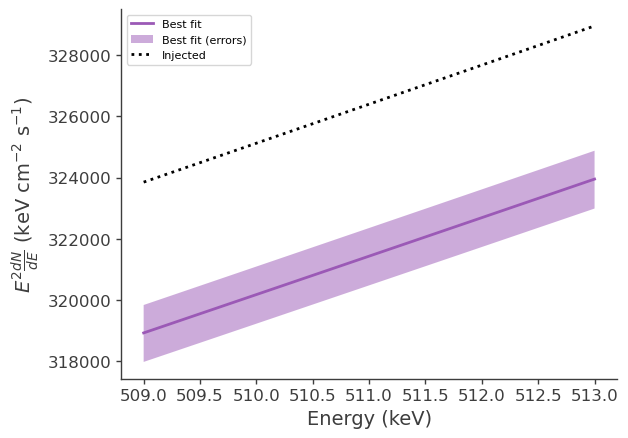

In [13]:
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*flux_median, label = "Best fit")
ax.fill_between(energy, energy*energy*flux_lo, energy*energy*flux_hi, alpha = .5, label = "Best fit (errors)")
ax.plot(energy, energy*energy*flux_inj, color = 'black', ls = ":", label = "Injected")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ (keV cm$^{-2}$ s$^{-1}$)")

ax.legend()

Plot the fitted spectrum convolved with the response, as well as the simulated source counts

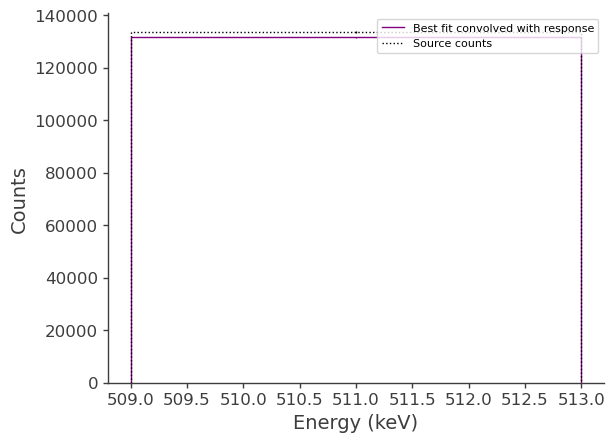

In [14]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents, yerr=np.sqrt(expectation.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(grb.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Source counts")
ax.errorbar(binned_energy, grb.binned_data.project('Em').todense().contents, yerr=np.sqrt(grb.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

Plot the fitted spectrum convolved with the response plus the fitted background, as well as the simulated source+background counts

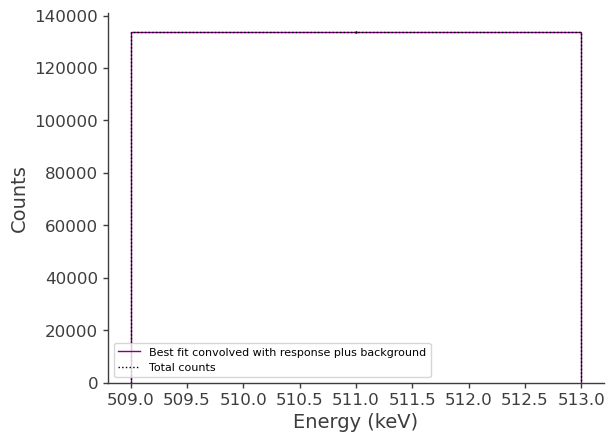

In [15]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), binned_energy_edges, color='purple', label = "Best fit convolved with response plus background")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), yerr=np.sqrt(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents)), color='purple', linewidth=0, elinewidth=1)
ax.stairs(grb_bkg.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Total counts")
ax.errorbar(binned_energy, grb_bkg.binned_data.project('Em').todense().contents, yerr=np.sqrt(grb_bkg.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

## Perform spectral fit (Dirac Delta function)

Set background parameter, which is used to fit the amplitude of the background, and instantiate the COSI 3ML plugin

In [16]:
bkg_par2 = Parameter("background_cosi",                                        # background parameter
                     2.8e-4,                                                   # initial value of parameter
                     min_value=0,                                              # minimum value of parameter
                     max_value=5,                                              # maximum value of parameter
                     delta=0.05,                                               # initial step used by fitting engine
                     desc="Background parameter for cosi")

cosi2 = COSILike("cosi",                                                       # COSI 3ML plugin
                 dr = dr,                                                      # detector response
                 data = grb_bkg.binned_data.project('Em', 'Phi', 'PsiChi'),    # data (source+background)
                 bkg = bkg.binned_data.project('Em', 'Phi', 'PsiChi'),         # background model 
                 sc_orientation = sc_orientation,                              # spacecraft orientation
                 nuisance_param = bkg_par2,                                    # background parameter
                 coordsys='spacecraftframe')                                   

Define a point source at the known location with a Dirac Delta function spectrum and add it to the model

In [17]:
value = 5 / u.cm / u.cm / u.s / u.keV
zero_point = 511. * u.keV  
spectrum2 = DiracDelta(value=value.value,
                      zero_point=zero_point.value)
spectrum2.zero_point.unit = zero_point.unit
spectrum2.value.unit = value.unit

source2 = PointSource("source",                     # Name of source (arbitrary, but needs to be unique)
                     l = l,                         # Longitude (deg)
                     b = b,                         # Latitude (deg)
                     spectral_shape = spectrum2)    # Spectral model

# Optional: free the position parameters
#source.position.l.free = True
#source.position.b.free = True

model2 = Model(source2)                             # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

# Optional: if you want to call get_log_like manually, then you also need to set the model manually
# 3ML does this internally during the fit though
cosi2.set_model(model2)

Now converting to the Spacecraft frame...
Conversion completed!


Gather all plugins and combine with the model in a JointLikelihood object, then perform maximum likelihood fit

In [18]:
plugins2 = DataList(cosi2) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like2 = JointLikelihood(model2, plugins2, verbose = False)

like2.fit()

15:51:47 INFO      set the minimizer to minuit                                             ]8;id=333954;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=240362;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply

There are bins in which the total expected counts = 0 but data != 0, making log-likelihood = -inf. Masking these bins.

WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply

There are bins in which the total expected counts = 0 but data != 0, making log-likelihood = -inf. Masking these bins.

WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING R

15:51:48 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=367415;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=794359;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
source.spectrum.main.DiracDelta.value,4.924 +/- 0.014,1 / (cm2 keV s)
background_cosi,(7.3 +/- 0.4) x 10^-3,


Correlation matrix:

1.00,-0.23
-0.23,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-62559.736853
total,-62559.736853


Values of statistical measures:

,statistical measures
AIC,-125121.473707
BIC,-125119.473707


(                                          value  negative_error  \
 source.spectrum.main.DiracDelta.value  4.923629       -0.013761   
 background_cosi                        0.007252       -0.000363   
 
                                        positive_error     error  \
 source.spectrum.main.DiracDelta.value        0.014012  0.013886   
 background_cosi                              0.000363  0.000363   
 
                                                   unit  
 source.spectrum.main.DiracDelta.value  1 / (cm2 keV s)  
 background_cosi                                         ,
        -log(likelihood)
 cosi      -62559.736853
 total     -62559.736853)

## Error propagation and plotting (Dirac Delta function)

Define spectrum injected into MEGAlib

In [19]:
value_inj = 5 / u.cm / u.cm / u.s / u.keV
zero_point_inj = 511. * u.keV

spectrum_inj2 = DiracDelta(value=value_inj.value,
                           zero_point=zero_point_inj.value)

spectrum_inj2.value.unit = value_inj.unit
spectrum_inj2.zero_point.unit = zero_point_inj.unit

The summary of the results above tell you the optimal values of the parameters, as well as the errors. Propogate the errors to the "evaluate_at" method of the spectrum

In [20]:
results2 = like2.results

print(results2.display())

parameters2 = {par.name:results2.get_variates(par.path)
               for par in results2.optimized_model["source"].parameters.values()
               if par.free}

results_err2 = results2.propagate(results2.optimized_model["source"].spectrum.main.shape.evaluate_at, **parameters2)

print(results2.optimized_model["source"])

Best fit values:

,result,unit
parameter,,
source.spectrum.main.DiracDelta.value,4.924 +/- 0.014,1 / (cm2 keV s)
background_cosi,(7.3 +/- 0.4) x 10^-3,


Correlation matrix:

1.00,-0.23
-0.23,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-62559.736853
total,-62559.736853


Values of statistical measures:

,statistical measures
AIC,-125121.473707
BIC,-125119.473707


None
  * source (point source):
    * position:
      * l:
        * value: 340.0
        * desc: Galactic longitude
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * b:
        * value: 45.0
        * desc: Galactic latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * DiracDelta:
          * value:
            * value: 4.923628936271557
            * desc: Constant value
            * min_value: null
            * max_value: null
            * unit: keV-1 s-1 cm-2
            * is_normalization: false
          * zero_point:
            * value: 511.0
            * desc: value at which function is non-zero
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
        * polarization: {}



Evaluate the flux and errors at 511 keV for the fitted and injected spectra

In [21]:
energy2 = 511.

flux2 = results_err2(energy2)
flux_median2 = flux2.median
flux_lo2, flux_hi2 = flux2.equal_tail_interval(cl=0.68)
flux_inj2 = spectrum_inj2.evaluate_at(energy2)
    
expectation2 = psr.get_expectation(spectrum2)

Plot the fitted and injected spectra

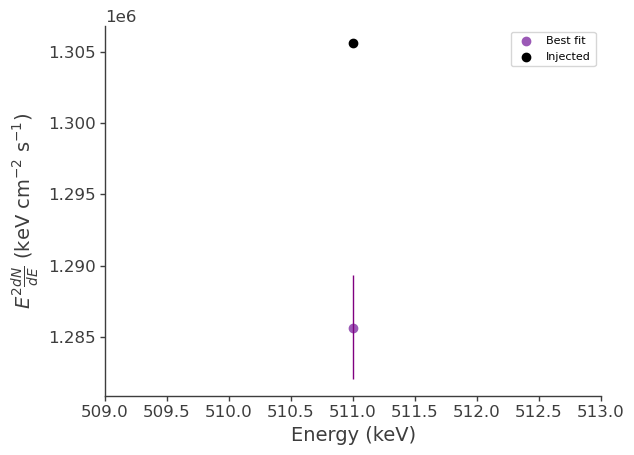

In [22]:
fig,ax = plt.subplots()

ax.scatter(energy2, energy2*energy2*flux_median2, label = "Best fit")
ax.errorbar(energy2, energy2*energy2*flux_median2, yerr=[[energy2*energy2*(flux_median2-flux_lo2)],[energy2*energy2*(flux_hi2-flux_median2)]], color='purple', linewidth=0, elinewidth=1)
ax.scatter(energy2, energy2*energy2*flux_inj2, color = 'black', label = "Injected")

ax.set_xlim(509,513)

ax.set_xlabel("Energy (keV)")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ (keV cm$^{-2}$ s$^{-1}$)")

ax.legend()

Plot the fitted spectrum convolved with the response, as well as the simulated source counts

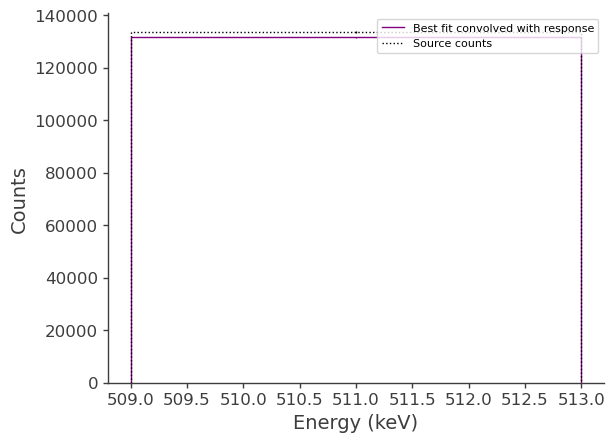

In [23]:
fig,ax = plt.subplots()

ax.stairs(expectation2.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, expectation2.project('Em').todense().contents, yerr=np.sqrt(expectation2.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(grb.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Source counts")
ax.errorbar(binned_energy, grb.binned_data.project('Em').todense().contents, yerr=np.sqrt(grb.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

Plot the fitted spectrum convolved with the response plus the fitted background, as well as the simulated source+background counts

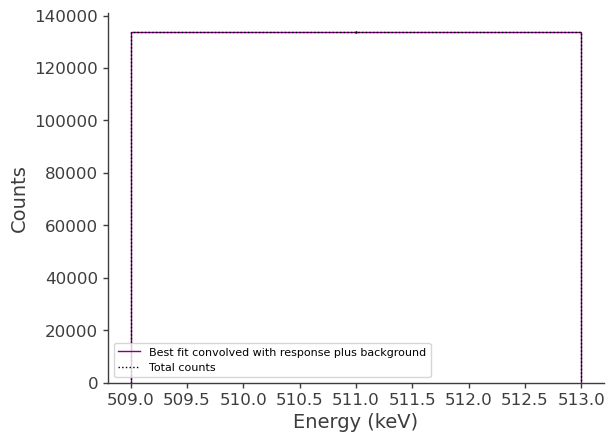

In [24]:
fig,ax = plt.subplots()

ax.stairs(expectation2.project('Em').todense().contents+(bkg_par2.value * bkg.binned_data.project('Em').todense().contents), binned_energy_edges, color='purple', label = "Best fit convolved with response plus background")
ax.errorbar(binned_energy, expectation2.project('Em').todense().contents+(bkg_par2.value * bkg.binned_data.project('Em').todense().contents), yerr=np.sqrt(expectation2.project('Em').todense().contents+(bkg_par2.value * bkg.binned_data.project('Em').todense().contents)), color='purple', linewidth=0, elinewidth=1)
ax.stairs(grb_bkg.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Total counts")
ax.errorbar(binned_energy, grb_bkg.binned_data.project('Em').todense().contents, yerr=np.sqrt(grb_bkg.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()